<a href="https://colab.research.google.com/github/LucasCRK/DL_project/blob/master/DL_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

There is no way to easily save variable state so I thik we just have to be careful to save regurlaly the model.


In [9]:
!pip install dgl
!pip install networkx
!pip install pin
!pip install gdown

  Using cached https://files.pythonhosted.org/packages/cf/81/f69af6685a26b435558bb7aead39127c38ce7dddb8d734a13db88ae3b9f8/pin-0.1rc1.tar.gz
ERROR: Command errored out with exit status 1: python setup.py egg_info Check the logs for full command output.


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [86]:
#Lucas experimenting in how to build graphs
import glob
import json
import numpy as np
import networkx as nx
import torch as th
import matplotlib.pyplot as plt
#from pin import ProteinGraph
import pandas as pd
#from Bio.PDB import PDBList, PDBIO, PDBParser
import os
from networkx.readwrite import json_graph
import json
import networkx as nx
import dgl
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn.pytorch import GATConv
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm


In [84]:
!unzip '/content/drive/My Drive/Ziv/courses/ML/DL_project/json-20200813T133030Z-001.zip'

Archive:  /content/drive/My Drive/Ziv/courses/ML/DL_project/json-20200813T133030Z-001.zip
  inflating: json/1ytw.json          
  inflating: json/1uk7.json          
  inflating: json/1g99.json          
  inflating: json/1dl5.json          
  inflating: json/1f9z.json          
  inflating: json/1dxe.json          
  inflating: json/1b73.json          
  inflating: json/2a0n.json          
  inflating: json/1e5q.json          
  inflating: json/1kzl.json          
  inflating: json/1h3i.json          
  inflating: json/1b2m.json          
  inflating: json/1jxh.json          
  inflating: json/1dnp.json          
  inflating: json/5a1i.json          
  inflating: json/1h3b.json          
  inflating: json/1i8t.json          
  inflating: json/3dgb.json          
  inflating: json/1pbg.json          
  inflating: json/1eg7.json          
  inflating: json/1a8h.json          
  inflating: json/1cbg.json          
  inflating: json/1ra0.json          
  inflating: json/2fqq.json         

In [70]:

json_files = glob.glob("/content/drive/My Drive/Ziv/courses/ML/DL_project/json/*.json")
print(len(json_files))
with open(json_files[0], 'r') as json_file:
  data = json.load(json_file) 
  graph = json.loads(data[0])
  labels = json.loads(data[1])


745


In [69]:
'''with open(json_files[0],'r') as jfile:
  graph = nx.node_link_graph(graph)
  g = dgl.DGLGraph()
  g.from_networkx(graph,node_attrs=['features','x','y','chain_id'],edge_attrs=['features'])'''

"with open(json_files[0],'r') as jfile:\n  graph = nx.node_link_graph(graph)\n  g = dgl.DGLGraph()\n  g.from_networkx(graph,node_attrs=['features','x','y','chain_id'],edge_attrs=['features'])"

In [78]:
print (graph['links'][0])
 

{'kind': ['backbone'], 'features': [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'source': 'A100THR', 'target': 'A99ASP'}


DGLGraph(num_nodes=192, num_edges=1932,
         ndata_schemes={'features': Scheme(shape=(36,), dtype=torch.float32), 'label': Scheme(shape=(192,), dtype=torch.float32)}
         edata_schemes={})


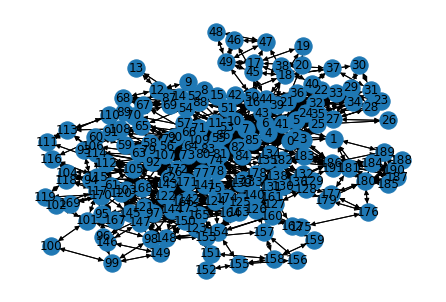

In [71]:
src = list()
dst = list()

# Get source and destination of edges
for i in  graph["links"]:
  src.append(int(i['source'][1:-3]))
  dst.append(int(i['target'][1:-3]))

# DGL graph has to start at 0 renumber AA
min_idx = np.min(src)
src = np.array(src) - min_idx
dst = np.array(dst) - min_idx

#Make Graph bidirectional
u = np.concatenate([src, dst])
v = np.concatenate([dst, src])

# Map features to node id
node_map = dict()
for i in graph["nodes"]:
  tmp = dict()
  tmp['label'] = labels[i['id']] 
  node_map[i["resi_num"] - min_idx] = {**i, **tmp}

# Create DGL object
G = dgl.DGLGraph((u,v))
pos = nx.kamada_kawai_layout(G.to_networkx())
nx.draw(G.to_networkx(), pos, with_labels=True)

label_tensor = th.tensor([node_map[i]['label'] for i in range(len(G))])


# Add features to each node
G.ndata['features'] = th.randn(len(G), len(node_map[0]['features'][0]))
G.ndata['label'] = th.randn(len(G), len(label_tensor))

print(G)
for i in node_map.keys():
  G.ndata['features'][i] = th.tensor(node_map[i]['features'][0])
  G.ndata['label'][i] = label_tensor


In [101]:
graph["links"][0]['features']

[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [39]:
G.edge_attr_schemes


<bound method DGLGraph.edge_attr_schemes of DGLGraph(num_nodes=192, num_edges=1932,
         ndata_schemes={'features': Scheme(shape=(36,), dtype=torch.float32), 'label': Scheme(shape=(192,), dtype=torch.float32)}
         edata_schemes={})>

In [ ]:
#Lucas end of experiment

In [141]:
class CustomDataset(Dataset):
    def __init__(self, path):
      json_files = glob.glob(path+"*.json")
      self.graphs=[]
      for fname in tqdm(json_files):
        with open(fname, 'r') as json_file:
          data = json.load(json_file) 
          graph = json.loads(data[0])
          labels = json.loads(data[1])
        
        src = list()
        dst = list()

  # Get source and destination of edges
        for i in  graph["links"]:
          src.append(int(i['source'][1:-3]))
          dst.append(int(i['target'][1:-3]))

  # DGL graph has to start at 0 renumber AA
        min_idx = np.min(src)
        src = np.array(src) - min_idx
        dst = np.array(dst) - min_idx

  #Make Graph bidirectional
        u = np.concatenate([src, dst])
        v = np.concatenate([dst, src])

  # Map features to node id
        node_map = dict()
        for i in graph["nodes"]:
          tmp = dict()
          tmp['label'] = labels[i['id']] 
          node_map[i["resi_num"] - min_idx] = {**i, **tmp}

  # Create DGL object
        G = dgl.DGLGraph((u,v))
      
        label_tensor = th.tensor([node_map[i]['label'] for i in range(len(G))])


  # Add features to each node
        G.ndata['features'] = th.randn(len(G), len(node_map[0]['features'][0]))
        G.ndata['label'] = th.randn(len(G), len(label_tensor))
      

        for i in node_map.keys():
          G.ndata['features'][i] = th.tensor(node_map[i]['features'][0])
          G.ndata['label'][i] = label_tensor      
      #for i in range(len(graph['links'])):
       #G.edata['features']=th.tensor(graph['links'][i]['features'])
      
      self.graphs.append(G)
        
          
    def __len__(self):
       
        return len(self.graphs)


    def __getitem__(self, idx):
        
    
        return self.graphs[idx], self.graphs[idx].ndata['label']

In [142]:

train_ds=CustomDataset('/content/json/')

KeyError: ignored

In [125]:
train_ds[0][0].shape

AttributeError: ignored

In [ ]:
def collate(samples):
    
    # The input `samples` is a list, a batch of whatever comes out of your dataset object
    
    graphs = [x[0] for x in samples]
    labels = [x[1] for x in samples]
    
    batched_graph = dgl.batch(graphs,node_attrs=['node_features'])
    targets = torch.cat(labels)
    
    return batched_graph, targets.unsqueeze(1).float()

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [138]:
class EdgeNetwork(nn.Module):
    def __init__(self):
        super(EdgeNetwork, self).__init__()
        
        self.edgelayer1=nn.Linear(128*2+36*2,128)
        self.edgelayer2=nn.Linear(128,256)
        
    def forward(self, x):
      #print(x.dst['node_features'].shape,x.src['node_hidden_state'].shape)
      x=torch.cat((x.dst['features'], x.dst['node_hidden_state'],x.src['features'], x.src['node_hidden_state']),dim=1)
      #print(x.shape)
      output=F.relu(self.edgelayer1(x))  
        #your input x is an object with the following properties:
        #x.dst['node_features'], x.dst['node_hidden_state']
        #x.src['node_features'], x.src['node_hidden_state']
        #x.data['distance']
        
        #put them together with torch.cat
        
        #use a neural network to create an edge hidden represetation - 
        
        #you return a dictionary with what you want to "send" to the reciving node
      output=self.edgelayer2(output) 
      return {'edge hidden represetation': output }

    
class NodeNetwork(nn.Module):
    def __init__(self):
        super(NodeNetwork, self).__init__()
        self.nodelayer1=nn.Linear(256+128+36,256)
        self.nodelayer2=nn.Linear(256,128)
        
    def forward(self, x):
      x_sum=torch.mean(x.mailbox['edge hidden represetation'],dim=1)
      #print(x_sum.shape, x.data['node_hidden_state'].shape, x.data['node_features'].shape)
      x=torch.cat((x_sum,x.data['node_hidden_state'], x.data['features']),dim=1)
      out=F.relu(self.nodelayer1(x))        
        #this time your input x has:
        # x.mailbox['edge hidden represetation'] -> this is what you send with the edge update function above - 
        # it will have the size of the node neighborhood - 
        # (Batch size, number of nodes in neighborhood, edge hidden rep size), so you need to sum/mean over dim=1 
        # x.data['node_hidden_state'] and x.data['node_features'] (this is the existing state of your node)
        # you need to torch.cat the message sum, node hidden state, and node features 
        #- and then apply some fully connected neural network
        
        # return a new hidden state for the node
      out=self.nodelayer2(out)
      return {'node_hidden_state': out }

class NodeNetworkClassifeir(nn.Module):
    def __init__(self):
        super(NodeNetworkClassifeir, self).__init__()
        
        self.nodelayerC1=nn.Linear(36+128,64)
        self.nodelayerC2=nn.Linear(64,1)
        
    def forward(self, x):
      #x_sum=torch.mean(x.mailbox['edge hidden represetation'],dim=1)
      x=torch.cat((x.data['features'], x.data['node_hidden_state']),dim=1)
      output=F.relu(self.nodelayerC1(x))  
        
      output=self.nodelayerC2(output) 
      return {'node_class_prediction': output }


class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        
        # you need to create a network that 
        # will initialize your node hidden state based only on the node features -
        self.node_feat_size=g.ndata['features'].shape[1]
        self.node_hid_size=128
        self.node_init = nn.Sequential(
                nn.Linear(36,64),
                nn.ReLU(),
            nn.Linear(64,self.node_hid_size))
        
        self.edge_network = EdgeNetwork()
        self.node_network = NodeNetwork()
        
        #this edge classifier is also an edge update function - 
        #but it needs to return something of size 1 (the edge class prediction)
        #so either create a different model for this, or make the EdgeNetwork configurable
        self.node_classifier = NodeNetworkClassifeir()
        
    def forward(self, g):
        
        g.ndata['node_hidden_state'] = self.node_init(g.ndata['features'])
        #print(g.ndata['node_hidden_state'].shape)
        for i in range(8):
            
            g.update_all(self.edge_network,self.node_network)
            
        
        #we want to classify the nodes - so finally apply your edge classifier -
        g.apply_nodes(self.node_classifier)
        
        #and extract its output 
        out = g.ndata['node_class_prediction']

        
        return out 

In [139]:
net=Classifier()

In [143]:
perd=net(train_ds[0][0])

In [145]:
len(perd)

313

In [ ]:
# the basic "graph attention layer" and the way to pass the information from node to node

class GATLayer(nn.Module):
    def __init__(self, g, in_dim, out_dim):
        super(GATLayer, self).__init__()
        self.g = g
        # equation (1)
        self.fc = nn.Linear(in_dim, out_dim, bias=False)
        # equation (2)
        self.attn_fc = nn.Linear(2 * out_dim, 1, bias=False)
        self.reset_parameters()

    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('relu')
        nn.init.xavier_normal_(self.fc.weight, gain=gain)
        nn.init.xavier_normal_(self.attn_fc.weight, gain=gain)

    def edge_attention(self, edges):
        # edge UDF for equation (2)
        z2 = torch.cat([edges.src['z'], edges.dst['z']], dim=1)
        a = self.attn_fc(z2)
        return {'e': F.leaky_relu(a)}

    def message_func(self, edges):
        # message UDF for equation (3) & (4)
        return {'z': edges.src['z'], 'e': edges.data['e']}

    def reduce_func(self, nodes):
        # reduce UDF for equation (3) & (4)
        # equation (3)
        alpha = F.softmax(nodes.mailbox['e'], dim=1)
        # equation (4)
        h = torch.sum(alpha * nodes.mailbox['z'], dim=1)
        return {'h': h}

    def forward(self, h):
        # equation (1)
        z = self.fc(h)
        self.g.ndata['z'] = z
        # equation (2)
        self.g.apply_edges(self.edge_attention)
        # equation (3) & (4)
        self.g.update_all(self.message_func, self.reduce_func)
        return self.g.ndata.pop('h')

In [ ]:
class MultiHeadGATLayer(nn.Module):
    def __init__(self, g, in_dim, out_dim, num_heads, merge='cat'):
        super(MultiHeadGATLayer, self).__init__()
        self.heads = nn.ModuleList()
        for i in range(num_heads):
            self.heads.append(GATLayer(g, in_dim, out_dim))
        self.merge = merge

    def forward(self, h):
        head_outs = [attn_head(h) for attn_head in self.heads]
        if self.merge == 'cat':
            # concat on the output feature dimension (dim=1)
            return torch.cat(head_outs, dim=1)
        else:
            # merge using average
            return torch.mean(torch.stack(head_outs))

In [ ]:
#the real model
class GAT(nn.Module):
    def __init__(self, g, in_dim, hidden_dim, out_dim, num_heads):
        super(GAT, self).__init__()
        self.layer1 = MultiHeadGATLayer(g, in_dim, hidden_dim, num_heads)
        # Be aware that the input dimension is hidden_dim*num_heads since
        # multiple head outputs are concatenated together. Also, only
        # one attention head in the output layer.
        self.layer2 = MultiHeadGATLayer(g, hidden_dim * num_heads, out_dim, 1)

    def forward(self, h):
        h = self.layer1(h)
        h = F.elu(h)
        h = self.layer2(h)
        return h

In [ ]:
# loading data here 
data_loader = DataLoader(train_ds, batch_size=30, shuffle=True,
                         collate_fn=collate)
data_loader_test=DataLoader(test_ds, batch_size=30,shuffle=True,collate_fn=collate)

In [ ]:
loss_func = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [ ]:
if torch.cuda.is_available():
    net.cuda()
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')

In [ ]:
##training for simple net
n_epoch = 20

epoch_losses, epoch_val_losses = [], []
for epoch in range(1, n_epoch+1):
    epoch_loss = 0
    iter_batch = 0
    net.train()
    for x, y in data_loader:
      x = x.to(torch.device('cuda'))
      y = y.cuda()

      prediction = net(x)
        
      loss = loss_func(prediction, y )
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      epoch_loss += loss.detach().item()
      iter_batch += 1
    epoch_loss /= (iter_batch + 1)
    #print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
    epoch_losses.append(epoch_loss)
    
    
    epoch_val_loss = 0
    iter_batch_val = 0
    net.eval()
    for bg, label in data_loader_test:
      bg=bg.to(torch.device('cuda'))
      label=label.cuda()   
      prediction = net(bg)
      loss = loss_func(prediction, label )
      epoch_val_loss += loss.detach().item()
      iter_batch_val += 1
    epoch_val_loss /= (iter_batch_val + 1)
    #print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
    epoch_val_losses.append(epoch_val_loss)
    print('Epoch {}, loss {:.4f}, val_loss {:.4f}'.format(epoch, epoch_loss, epoch_val_loss))

In [ ]:
##training.

import time
import numpy as np

g, features, labels, mask = load_cora_data()

# create the model, 2 heads, each head has hidden size 8
net = GAT(g,
          in_dim=features.size()[1],
          hidden_dim=8,
          out_dim=7,
          num_heads=2)

# create optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

# main loop
dur = []
for epoch in range(30):
    if epoch >= 3:
        t0 = time.time()

    logits = net(features)
    logp = F.log_softmax(logits, 1)
    loss = F.nll_loss(logp[mask], labels[mask])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch >= 3:
        dur.append(time.time() - t0)

    print("Epoch {:05d} | Loss {:.4f} | Time(s) {:.4f}".format(
        epoch, loss.item(), np.mean(dur)))